## Image processing tutorial for Philipp
- <a href='#modules'>Import modules</a>
- <a href='#specifydirectory'>Specify experiment directory</a>
- <a href='#makedict'>Make empty dictionary to store results</a>
- <a href='#makepdfs'>Make PDFs of raw images</a>
- <a href='#loadingprocessinganalysing'>Loading, processing and batch analyzing the images</a>
    - <a href='#preprocessing'>Preprocessing</a>
    - <a href='#segmenting'>Segmenting</a>
- <a href='#quantitativeimageanalysis'>Quantitative image analysis</a>
- <a href='#plots'>Plots</a>
    - <a href='#checknormality'>Check normality</a>
    - <a href='#barplots'>Barplots</a>
    - <a href='#boxwhisker'>Box and whisker plots</a>
    - <a href='#violinplots'>Violin plots</a>
- <a href='#makingsense'>Making sense</a>

<a id='modules'></a> 
### Import modules
These contain all the functions we will be using for the analysis

In [36]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

<a id='specifydirectory'></a> 
### Specify experiment directory
- Experimental conditions are named after the folders in the directory
- Channel numbers of each condition (ECM, synapses, nuclei) is read from the file channels.txt in the directory

In [37]:
expdir='/Volumes/ukps-all$/AG-Rizzoli/Gabriel/' #master folder
protein="NE" #TNR,Agg,WFA,HABP

<a id='makedict'></a> 
### Make an empty dictionary to store all the results we want to calculate
- The dictionary 'results' will store the mean of each result for each image (e.g. mean intensity of the image)
- The dictionary 'histogram_results' will store the histograms of the intensities for each image
- The dictionary 'region_props' will store the region properties of the 'spots' (individual, discrete objects) that are detected in the images in the segmentation stage. These are morphological/geographical parameters like location, area, perimeter, etc.

In [44]:
results = {"filename":[],
           "ecmchannelno":[],"nucleichannelno":[],"synapsechannelno":[],"noblock_controldir":[],
           "Soma mask from synapse channel":[],
           "Neurites mask from synapse channel":[],
           "Manual mask from matlab GUI":[],
           "exp condition":[],
           "ECM raw intensity, unmasked":[],
           "Nuclei raw intensity, unmasked":[],
           "Synapse raw intensity, unmasked":[],
           "ECM intensity: unmasked, divded by unblocked condition":[],
           "ECM mean intensity: soma only":[],
           "ECM mean intensity: soma only, divided by unblocked":[],
           "ECM mean intensity: neurites only":[],
           "ECM mean intensity: neurites only, divided by unblocked":[],
           "ECM mean intensity: matlab manual mask only":[],
           "ECM mean intensity: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity: soma only":[],
           "Synapse mean intensity: neurites only":[],
           "Synapse mean intensity: matlab manual mask only":[],
           "Nuclei mean intensity: soma only":[],
           "Nuclei mean intensity: neurites only":[],
           "Nuclei mean intensity: matlab manual mask only":[],
           "Number of synapse spots in soma mask":[],
           "Number of synapse spots in neurites mask":[],
           "Number of synapse spots in matlab manual mask":[],
           "Number of nuclei spots in soma mask":[],
           "Number of nuclei spots in neurites mask":[],
           "Number of nuclei spots in matlab manual mask":[],
           "ECM mean intensity after bg subtraction: soma only":[],
           "ECM mean intensity after bg subtraction: soma only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: neurites only":[],
           "ECM mean intensity after bg subtraction: neurites only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity after bg subtraction: soma only":[],
           "Synapse mean intensity after bg subtraction: neurites only":[],
           "Synapse mean intensity after bg subtraction: matlab manual mask only":[],
           "Number of synapse spots in soma mask after bg subtraction":[],
           "Number of synapse spots in neurites mask after bg subtraction":[],
           "Number of synapse spots in matlab manual mask after bg subtraction":[],
           "Number of nuclei spots in soma mask after bg subtraction":[],
           "Number of nuclei spots in neurites mask after bg subtraction":[],
           "Number of nuclei spots in matlab manual mask after bg subtraction":[]}
          
histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "Nuclei raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if (protein in str(filelist[i]))==True:
            if filelist[i].endswith(".nd2"): 
                results["filename"].append(filelist[i])
                histogram_results["filename"].append(filelist[i])
                regionprops_results["filename"].append(filelist[i])
                results["exp condition"].append(filelist[i].split('/')[-2])
                histogram_results["exp condition"].append(filelist[i].split('/')[-2])
                regionprops_results["exp condition"].append(filelist[i].split('/')[-2])
                channeldir="/".join(filelist[i].split("/")[:-2])
                exec(open(channeldir+"/channels.txt").read())
                results["ecmchannelno"].append(ecmchannelno)
                results["nucleichannelno"].append(nucleichannelno)
                results["synapsechannelno"].append(synapsechannelno)
                
                positivecontrolcheck=Path(channeldir+"/Ctrl_NoBlocking")
                if positivecontrolcheck.exists():
                    results["noblock_controldir"].append(channeldir+"/Ctrl_NoBlocking")                

**Let's take a look at which experimental conditions we have**

In [45]:
print("\n".join(list(sorted(set(results["exp condition"])))))

12hrs_Bic
12hrs_DMSO
2hrs_Bic
2hrs_DMSO
4hrs_Bic
4hrs_DMSO
Ctrl_NoBlocking


<a id='loadingprocessinganalysing'></a> 
## Loading, processing and batch analyzing the images

What the Nikon gives us is a matrix of numbers, where is number represents the intensity of the signal in that spot (based on the number of photons that hit the camera bin).

![title](./digitalimagesfigure1.jpg)

We will load these matrices, clean them with different mathematical operations, and then quantitate a variety of results in a loop over all the images.

<a id='#preprocessing'></a> 
### Preprocessing of the images - cleaning and segmenting (detecting individual 'spots')
- Here, we will load an image from each channel (ECM, nuclei, synapses) and then use different image processing techniques to find the pixels in the image which we think are the real signal.
- We will then make a **mask** for each channel. This is a *logical matrix*, of the same size as the image, where each pixel is either True or False (1 or 0). True means that the pixel lying underneath in the real image is signal, and 0 means that it's noise.
- We never toss away the original ('raw') image. We'll simply use the mask to know which regions of the raw images should be included in the calculation, and which shouldn't.
- Also, we can give a unique 'id' to each continuous region in the mask (where several '1' value pixels are touching). Each of these regions represents a unique 'spot'/object in our image. This is called segmentation - i.e. splitting the image into meaningful segments.

**Let's start by loading a random image and looking at the ECM channel:**

Image name: 20181211_NE_08_005.nd2
Experimental condition: 4hrs_DMSO


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

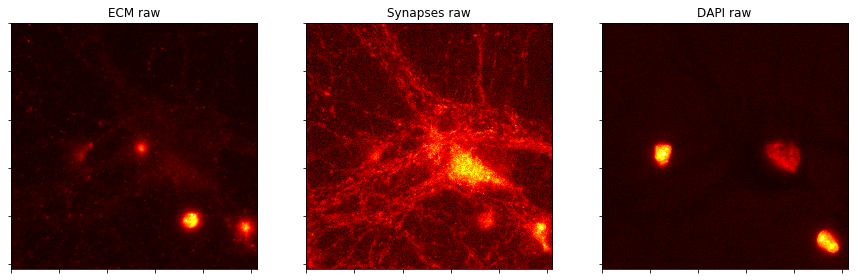

In [46]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


**Let's take a look at the image histogram to get a better idea of its properties:**

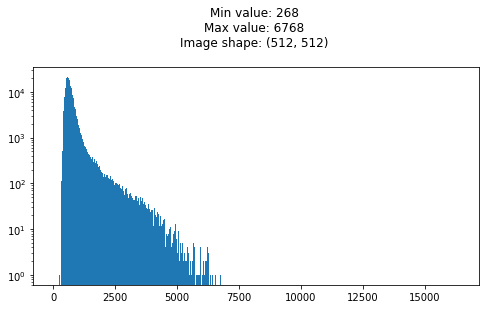

In [8]:
fig,ax = plt.subplots(figsize=(8, 4))
ax.hist(ecm_image.flatten(), log=True,
        bins=600, range=(0, 16383))
_ = ax.set_title('Min value: %i \n'
                 'Max value: %i \n'
                 'Image shape: %s \n'
                 % (ecm_image.min(),
                    ecm_image.max(),
                    ecm_image.shape))

The image histogram is a graph of the number of pixels (y axis) at each intensity value (x axis). What we (should) see:
- The biggest peak is at the low intensities - this is mostly noise.
- The rest of the pixels should distribute over a wide range of values without any more major peaks. We shouldn't have too many pixels approaching the maximal values (16383 for the Nikon).
    - The Nikon camera has a bit depth of 14. This means each pixel can get a possible value between 0 and 16383 (i.e. 2^14 possible values). We should hope to use as much of this range as possible to get as much information as we can from the image.
    - However, we should only really approach maximum values in our brightest sample, and even then - we shouldn't have many values in this region. If we do, that means we probably 'saturated' some of our pixels, i.e. in reality they should have a higher value but our camera isn't sensitive to this. If we see a big peak at the high intensity values, we probably over-exposed our sample.
    - The wider the range of our histogram (i.e. the smaller the minimum and the higher the maximum), the more contrast (difference between bright and dark) we can get in our image --> the more information we can derive.

#### Denoising the image:
Background signal (noise) in our image can come from different sources, for example:
- Secondary antibodies or primary-secondary complexes that don't actually bind our protein but didn't wash away
- Variations in the intensity of the fluorophores in different samples/locations due to uneven mounting
- Natural variance of the optic signal itself (amount of photons emitted)
- Uneven illumination by the microscope lens
- Errors in the detector (camera), e.g. random discharge causes an incorrect signal

There are many different approaches to removing noise. Considering that a lot of our noise is very low intensity values, we could simply do a global threshold (and throw away everything below some intensity value). However, this isn't ideal: there are areas in an image which are naturally dimmer, and thresholding here might cause us to lose information. 

A solution to this 'non-uniform background' problem is to do **adaptive thresholding**. With this approach, the threshold is calculated for neighbourhoods of pixels rather than globally for the whole image. We will do adaptive Gaussian thresholding:
- First, we do a **Gaussian filter** on the image. This means we replace each pixel in our image with the sum of its neighbourhood multiplied by a Gaussian shape. So - nearer pixels are given more weight and further pixels are given less weight. This reduces sharp contrasts between neighbouring pixels and smooths out the image.
    - Change the sigma of the Gaussian bell to determine the extent of the smoothing. The sigma should be approximately half the size (in pixels) of the objects you're expecting in your image.
- Second, we will do a **mean filter** to further smooth this image. In this case each pixel is replaced with the average of the pixels in its neighbourhood. We can decide the shape and size of this neighbourhood. This shape is called the *structuring element*. 
    - Our structural element will be a circle. Change the i to alter the size of this circle.

This double-smoothed image now represents our threshold. Wherever the original image is higher than its corresponding pixel in this background image - is our real signal.

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


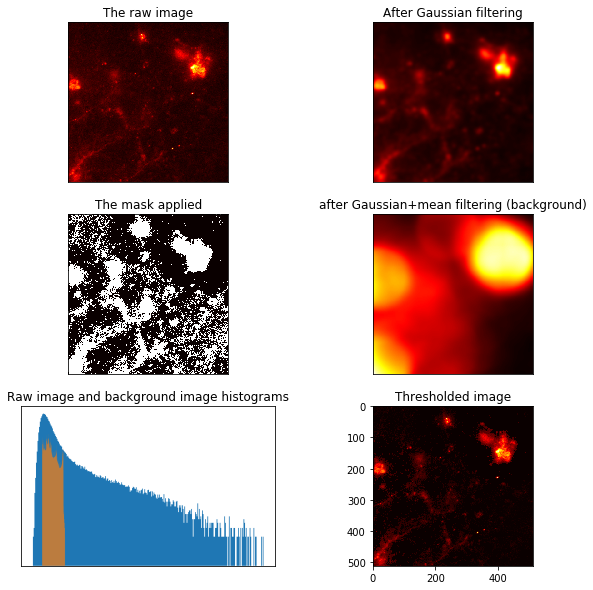

In [9]:
sigmagauss_ecm=5 #change me
ecm_smooth = ndi.filters.gaussian_filter(ecm_image,sigmagauss_ecm)

istruct_ecm=200 #change me
struct_ecm = (np.mgrid[:istruct_ecm,:istruct_ecm][0] - np.floor(istruct_ecm/2))**2 + (np.mgrid[:istruct_ecm,:istruct_ecm][1] - np.floor(istruct_ecm/2))**2 <= np.floor(istruct_ecm/2)**2
bg_ecm = rank.mean(ecm_smooth, selem=struct_ecm)

ecm_denoised=ecm_image>bg_ecm
ecm_thresholded=deepcopy(ecm_image)
ecm_thresholded[~ecm_denoised]=ecm_image.max()+1
ecm_thresholded[ecm_thresholded==(ecm_image.max()+1)]=ecm_thresholded.min()

fig=plt.figure(figsize=(10,10))
fig.add_subplot(321)
plt.title('The raw image')
plt.imshow(ecm_image,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(322)
plt.title('After Gaussian filtering')
plt.imshow(ecm_smooth,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(323)
plt.title('The mask applied')
plt.imshow(ecm_denoised,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(324)
plt.title('after Gaussian+mean filtering (background)')
plt.imshow(bg_ecm,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(325)
plt.title('Raw image and background image histograms')
plt.hist(ecm_image.flatten(),log=True,bins=300,histtype='stepfilled')
plt.hist(bg_ecm.flatten(),log=True,bins=300,alpha=0.7,histtype='stepfilled')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(326)
plt.title('Thresholded image')
plt.imshow(ecm_thresholded,interpolation='None',cmap='hot')

#### Removing other artifacts
We also noticed that we tend to get these very bright big spots in our images, which are likely due so some secondaries clustering together and/or sticking to some dead, floating cells in our sample. Here we can try regular global thresholding to remove them.

Let's just remove everything in the images above the 99th percentile:

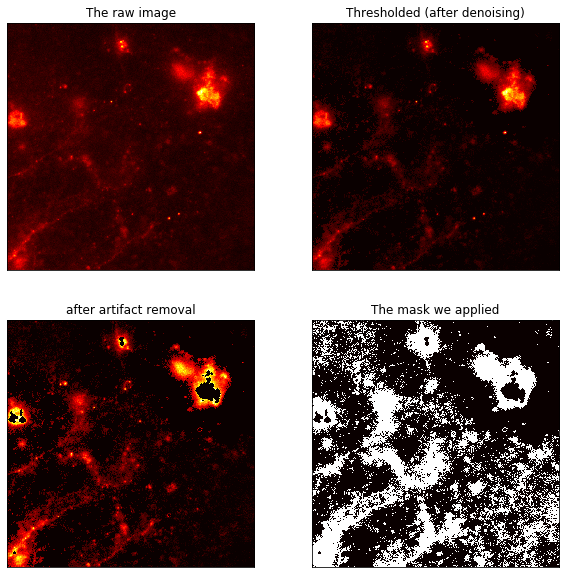

In [10]:
ecm_not_toobright=np.logical_not(ndi.morphology.binary_dilation(ecm_image>np.percentile(ecm_image,99.5),iterations=2))
ecm_spots=ecm_not_toobright & ecm_denoised
ecm_cleaned=deepcopy(ecm_image)
ecm_cleaned[~ecm_spots]=ecm_image.max()+1
ecm_cleaned[ecm_cleaned==(ecm_image.max()+1)]=ecm_cleaned.min()

fig=plt.figure(figsize=(10,10))
fig.add_subplot(221)
plt.title('The raw image')
plt.imshow(ecm_image,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(222)
plt.title('Thresholded (after denoising)')
plt.imshow(ecm_thresholded,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(223)
plt.title('after artifact removal')
plt.imshow(ecm_cleaned,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(224)
plt.title('The mask we applied')
plt.imshow(ecm_spots,interpolation='None',cmap='hot')
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#### Cleaning all the channels
Let's perform the same cleaning operations on the other channels. When we run the analysis over all of our images, we won't want to clean each one individually because this would take a *long* time. 

We will do this here for three random images from our experiment, and these parameters will then be applied to the remaining images too.

For the other channels, our parameters will need to be different:
- For the nuclei, we just want the big bright spots. Therefore, our sigma will be big and we will want to keep the bright signal only.
- For the synapses, we can probably detect smaller spots (we can try a smaller sigma).

/Volumes/ukps-all$/AG-Rizzoli/Gabriel/20181211_NE_analyse/12hrs_Bic/20181211_NE_02_004.nd2


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


/Volumes/ukps-all$/AG-Rizzoli/Gabriel/20181204_NE_analyse/12hrs_Bic/20181204_NE_02_100x_005.nd2


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


/Volumes/ukps-all$/AG-Rizzoli/Gabriel/20181211_NE_analyse/4hrs_Bic/20181211_NE_05_002.nd2


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


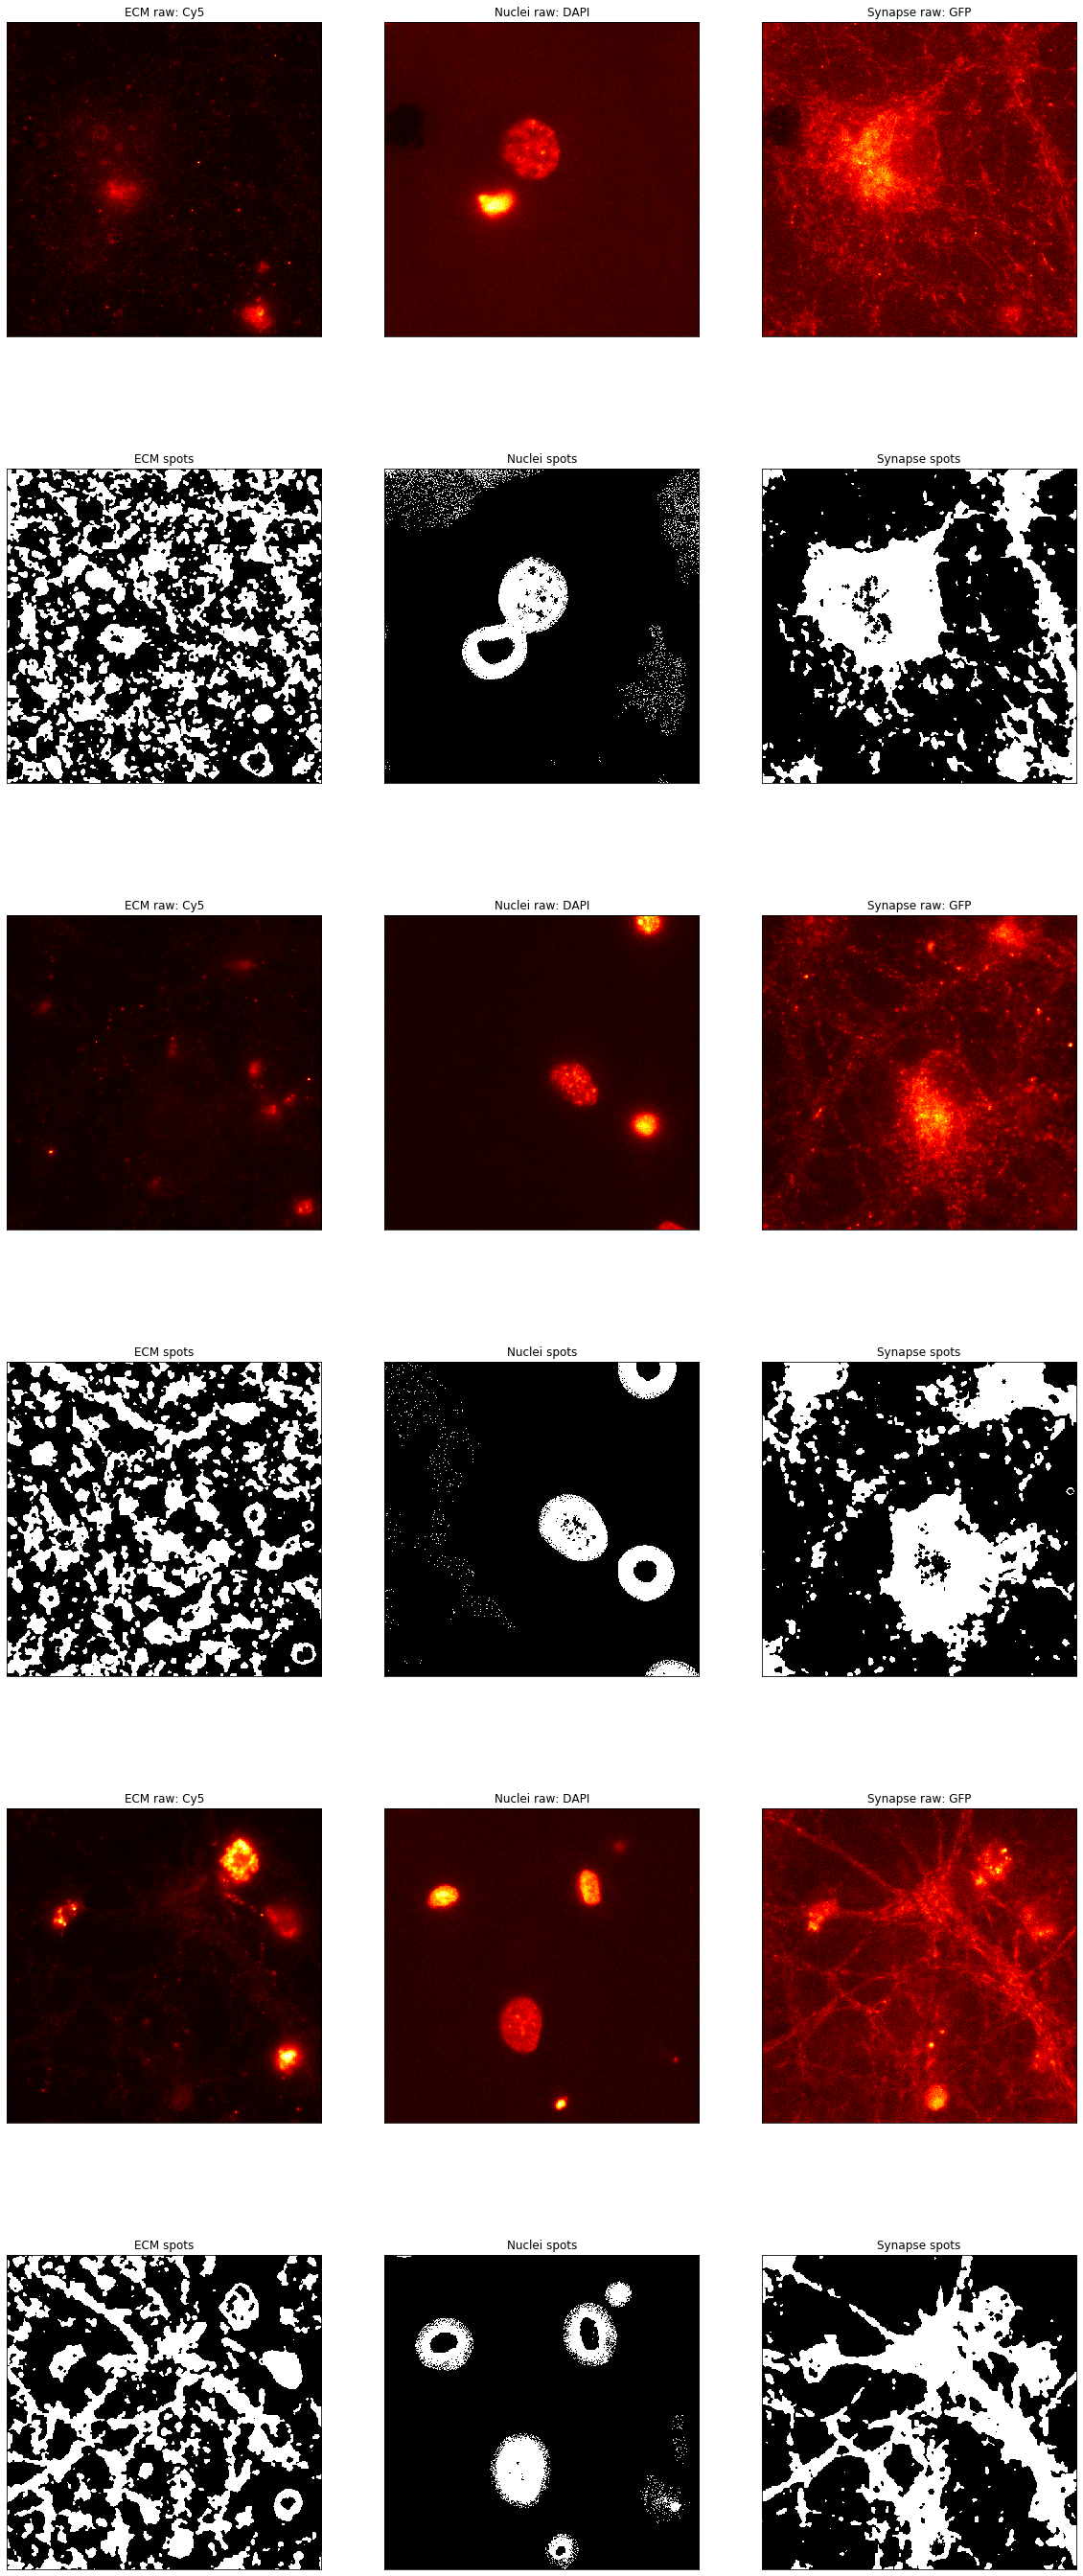

In [11]:
#########change us:############
sigmagauss_ecm=2 
istruct_ecm=80 #for SE
sigmagauss_synapses=2
istruct_synapses=500
sigmagauss_nuclei=10
istruct_nuclei=300
##############################

fig=plt.figure(figsize=(20,50))
figno=1
for im in range(0,3): #load 3 random images from the directory
    randomno=np.random.randint(1,len(results["filename"]))
    ecm_channel_no=results["ecmchannelno"][randomno]
    nuclei_channel_no=results["nucleichannelno"][randomno]
    synapse_channel_no=results["synapsechannelno"][randomno]
    with ND2Reader(results["filename"][randomno]) as images:
        print(results["filename"][randomno])
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
        [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
        if ecm_channel_no==1:
            ecm_channelname=channel1name
            if nuclei_channel_no==2:
                nuclei_channelname=channel2name
                synapse_channelname=channel3name
            else:
                nuclei_channelname=channel3name
                synapse_channelname=channel2name
        if ecm_channel_no==2:
            ecm_channelname=channel2name
            if nuclei_channel_no==3:
                nuclei_channelname=channel3name
                synapse_channelname=channel1name
            else:
                nuclei_channelname=channel1name
                synapse_channelname=channel3name
        if ecm_channel_no==3:
            ecm_channelname=channel3name
            if nuclei_channel_no==2:
                nuclei_channelname=channel2name
                synapse_channelname=channel1name
            else:
                nuclei_channelname=channel1name
                synapse_channelname=channel2name
                
    
    ecm_smooth = ndi.filters.gaussian_filter(ecm_image,sigmagauss_ecm)
    nuclei_smooth = ndi.filters.gaussian_filter(nuclei_image,sigmagauss_nuclei)
    synapse_smooth=ndi.filters.gaussian_filter(synapse_image,sigmagauss_synapses)
    struct_ecm = (np.mgrid[:istruct_ecm,:istruct_ecm][0] - np.floor(istruct_ecm/2))**2 + (np.mgrid[:istruct_ecm,:istruct_ecm][1] - np.floor(istruct_ecm/2))**2 <= np.floor(istruct_ecm/2)**2
    struct_nuclei = (np.mgrid[:istruct_nuclei,:istruct_nuclei][0] - np.floor(istruct_nuclei/2))**2 + (np.mgrid[:istruct_nuclei,:istruct_nuclei][1] - np.floor(istruct_nuclei/2))**2 <= np.floor(istruct_nuclei/2)**2
    struct_synapses = (np.mgrid[:istruct_synapses,:istruct_synapses][0] - np.floor(istruct_synapses/2))**2 + (np.mgrid[:istruct_synapses,:istruct_synapses][1] - np.floor(istruct_synapses/2))**2 <= np.floor(istruct_synapses/2)**2
    
    #next we do an average filter of this blurred image to smooth it even more
    bg_ecm = rank.mean(ecm_smooth, selem=struct_ecm)
    bg_nuclei = rank.mean(nuclei_smooth, selem=struct_nuclei)
    bg_synapse = rank.mean(synapse_smooth, selem=struct_synapses)
    #our signal is where the smoothed image is brighter than the averaged-smoothed image
    ecm_denoised = ecm_smooth >= bg_ecm
    nuclei_denoised = nuclei_smooth >= bg_nuclei
    synapse_denoised = synapse_smooth >= bg_synapse
    
    #global thresholding to remove big artifacts
    ecm_not_toobright=np.logical_not(ndi.morphology.binary_dilation(ecm_image>np.percentile(ecm_image,99.8),iterations=2))
    nuclei_not_toodim=np.logical_not(nuclei_image<np.percentile(nuclei_image,80))
    nuclei_not_toobright=np.logical_not(nuclei_image>np.percentile(nuclei_image,99))
    synapse_not_toobright=np.logical_not(ndi.morphology.binary_dilation(synapse_image>np.percentile(synapse_image,99.8),iterations=2))
    
    #final spots
    ecm_spots=ecm_not_toobright & ecm_denoised
    nuclei_spots=nuclei_not_toodim & nuclei_denoised & nuclei_not_toobright
    synapse_spots=synapse_not_toobright & synapse_denoised

    #figures    
    fig.add_subplot(6,3,figno)
    plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=1.5*ecm_image.min(),vmax=0.95*ecm_image.max())
    plt.title('ECM raw: '+ecm_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,3,figno+1)
    plt.imshow(nuclei_image,interpolation='none',cmap='hot')
    plt.title('Nuclei raw: '+nuclei_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,3,figno+2)
    plt.imshow(synapse_image,interpolation='none',cmap='hot')
    plt.title('Synapse raw: '+synapse_channelname)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,3,figno+3)
    plt.imshow(ecm_spots,interpolation='none',cmap='gray')
    plt.title('ECM spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,3,figno+4)
    plt.imshow(nuclei_spots,interpolation='none',cmap='gray')
    plt.title('Nuclei spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(6,3,figno+5)
    plt.imshow(synapse_spots,interpolation='none',cmap='gray')
    plt.title('Synapse spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    figno=figno+6

### Automatic masking

Another thing we could try to save some time is to let the computer make a rough mask for us. This script automatically makes  a separate mask for the cell soma and for the neurites using the following technique:
 
- Threshold with Li method (minimizing cross entropy) on the synapse channel
- Make a separate mask for soma and neurites:
    - Find the soma by labelling the binary mask --> largest connected component = soma
    - Blur soma --> save this as soma mask
    - Blue remaining area --> save this as neurite mask

Run below to see an example of a random image after masking

Text(0.5, 1.0, 'ECM raw image')

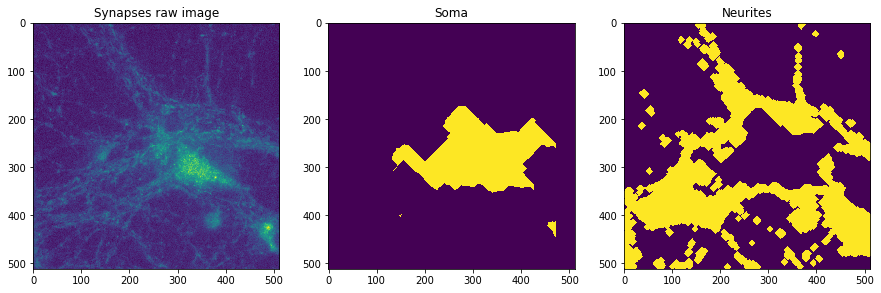

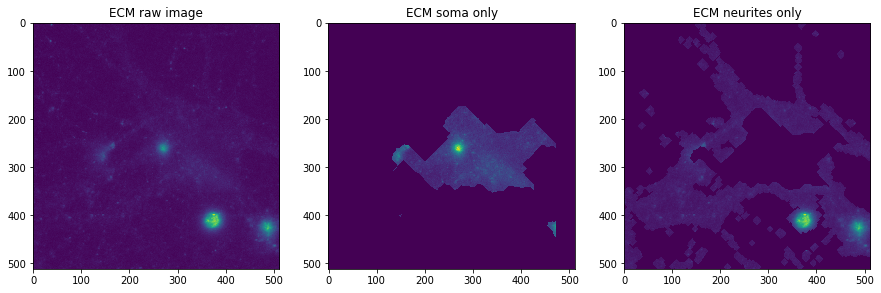

In [47]:
def makemask(synapse_image):
    #li thresholding
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    #find soma + some morphological operations
    synapse_labeled_mask, cc_num = ndi.label(synapse_image_thresholded)
    synapse_largest_cc_mask = (synapse_labeled_mask == (np.bincount(synapse_labeled_mask.flat)[1:].argmax() + 1))
    soma_mask=ndi.binary_closing(ndi.gaussian_filter(synapse_largest_cc_mask,sigma=1),iterations=40)
    #some morphological operations on the neurite mask
    neurite_mask=deepcopy(synapse_image_thresholded)
    neurite_mask[neurite_mask>np.percentile(neurite_mask,99.5)]=0
    neurite_mask[soma_mask]=0
    neurite_mask=ndi.gaussian_filter(neurite_mask,sigma=0.5)
    neurite_mask[neurite_mask>0]=1
    neurite_mask=ndi.binary_erosion(neurite_mask,iterations=4)
    neurite_mask=ndi.binary_dilation(neurite_mask,iterations=7)
    neurite_mask=ndi.binary_fill_holes(neurite_mask)
    return(soma_mask,neurite_mask)
    
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
soma_mask,neurite_mask=makemask(synapse_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurite_mask]=0
    
#show
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(synapse_image)
plt.title('Synapses raw image')
fig.add_subplot(132)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(133)
plt.imshow(neurite_mask)
plt.title('Neurites')

fig=plt.figure(figsize=(15,15))
fig.add_subplot(132)
plt.imshow(ecm_somamasked)
plt.title('ECM soma only')
fig.add_subplot(133)
plt.imshow(ecm_neuritemasked)
plt.title('ECM neurites only')
fig.add_subplot(131)
plt.imshow(ecm_image)
plt.title('ECM raw image')

<a id='segmenting'></a> 
#### Make masks for all images
Run here to make auto-masks for all images in the folder

In [48]:
print('Total number of images: ' + str(len(results['filename'])))

for im in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(im+1) + 'of ' + str(len(results['filename'])))
    ecm_channel_no=results["ecmchannelno"][im]
    nuclei_channel_no=results["nucleichannelno"][im]
    synapse_channel_no=results["synapsechannelno"][im]
    with ND2Reader(results["filename"][im]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
        
    soma_mask,neurite_mask=makemask(synapse_image)
    
    results["Soma mask from synapse channel"].append(soma_mask)
    results["Neurites mask from synapse channel"].append(neurite_mask)
    clear_output()        

os.system('say "Segmentation complete"')
print("Done!")

Done!


### Manual masking:
As you can see, the automatic masks, and even the ones made by adaptive thresholding aren't 'ideal'. Still, the best technique is to manually select the regions that look good and worth analyzing. What does that mean? --> a part of the image which is:
- In focus
- Doesn't contain very bright artifacts
- Doesn't look too noisy
- Looks good biologically (healthy cells, without odd morphologies)
For this, you use the Matlab interface to select ROIs (regions of interest) in each image, which will be used as a mask for the image.

#### If they have already been made, load manual segmentation masks from matlab GUI

In [49]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_mask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


** If the matlab masks haven't been made - run the script below to insert 'empty' masks into the file instead**

In [15]:
for i in range(len(results["ecmchannelno"])):
    results["Manual mask from matlab GUI"].append(np.nan)

**Backup the segmentation results before continuing**

We will copy the results dictionary that we've filled so far with the segmentation results, just in case...
Note - this copy stays alive along as this notebook stays alive, i.e. it isn't saved on the hard disk

In [28]:
resultsbackup=deepcopy(results)

*Restore results from backup, if needed:*

In [ ]:
results=deepcopy(resultsbackup)

### Visualize automatic masking (and manual, if exists) and background reduction for a few random images

Image name: 20181204_NE_06_100x_004.nd2
Experimental condition: 4hrs_Bic
ECM image - raw mean intensity =  490.05023193359375
ECM under soma - mean intensity =  543.0348141819735
ECM under soma - mean intensity after bg subtraction =  30.183167874056096
ECM under neurites - mean intensity =  575.6875238927421
ECM under neurites - mean intensity after bg subtraction =  67.0495612024858
ECM under manual mask - mean intensity =  475.6271543790368
ECM under manual rois mask - mean intensity after bg subtraction =  41.9035427423462


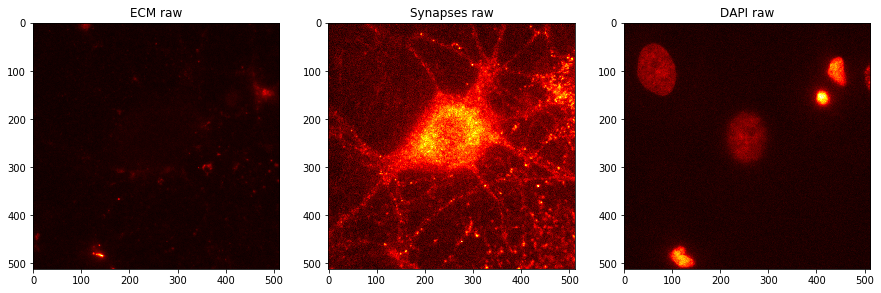

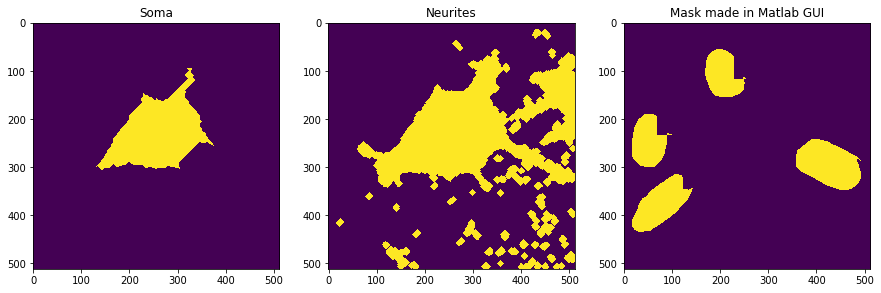

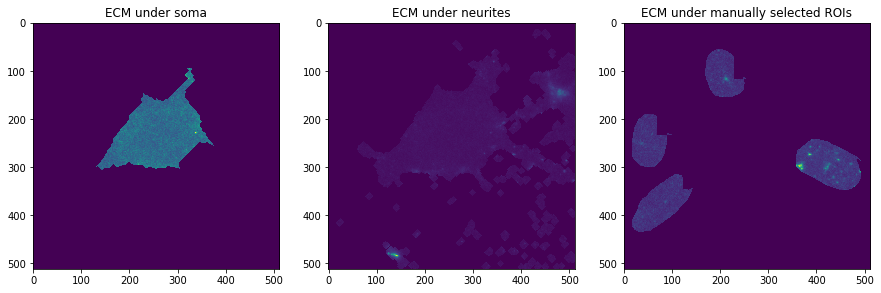

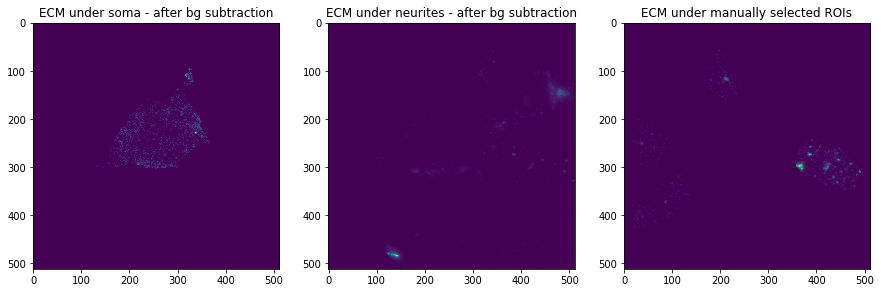

In [50]:
flag=False
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
soma_mask=results["Soma mask from synapse channel"][randomno]
neurites_mask=results["Neurites mask from synapse channel"][randomno]
matlab_mask=results["Manual mask from matlab GUI"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name
            
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurites_mask]=0
ecm_matlabmasked=deepcopy(ecm_image)
synapses_matlabmasked=deepcopy(synapse_image)
if type(matlab_mask)==np.ndarray:
    ecm_matlabmasked[~matlab_mask]=0
    synapses_matlabmasked[~matlab_mask]=0
    flag=True

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')

#show masks
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(132)
plt.imshow(neurites_mask)
plt.title('Neurites')
fig.add_subplot(133)
if flag==True:
    plt.imshow(matlab_mask)
    plt.title('Mask made in Matlab GUI')
else:
    plt.imshow(np.zeros([512,512]))
    plt.title('Mask made in Matlab GUI - no mask was made') 
#show masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(ecm_somamasked)
plt.title('ECM under soma')
fig.add_subplot(132)
plt.imshow(ecm_neuritemasked)
plt.title('ECM under neurites')
fig.add_subplot(133)
if flag==True:
    plt.imshow(ecm_matlabmasked)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked)
    plt.title('No manual mask was made') 
#background subtraction    
bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
ecm_somamasked_bgreduced=deepcopy(ecm_image)
ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
ecm_somamasked_bgreduced[~soma_mask]=0
bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
ecm_neuritesmasked_bgreduced[~neurites_mask]=0
ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
if flag==True:
    bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
    ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
    ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
    ecm_matlabmasked_bgreduced[~matlab_mask]=0

#show bg subtracted masked images
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(ecm_somamasked_bgreduced)
plt.title('ECM under soma - after bg subtraction')
fig.add_subplot(132)
plt.imshow(ecm_neuritesmasked_bgreduced)
plt.title('ECM under neurites - after bg subtraction')
fig.add_subplot(133)
if flag==True:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('No manual mask was made')
#calculate intensities before/after bg subtraction
print('ECM image - raw mean intensity = ',np.nanmean(ecm_image))
print('ECM under soma - mean intensity = ',np.nanmean(ecm_image[soma_mask]))
print('ECM under soma - mean intensity after bg subtraction = ', np.nanmean(ecm_somamasked_bgreduced[soma_mask]))
print('ECM under neurites - mean intensity = ',np.nanmean(ecm_image[neurites_mask]))
print('ECM under neurites - mean intensity after bg subtraction = ', np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]))
if flag==True:
    print('ECM under manual mask - mean intensity = ',np.nanmean(ecm_image[matlab_mask]))
    print('ECM under manual rois mask - mean intensity after bg subtraction = ', np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))

<a id='quantitativeimageanalysis'></a> 
### Quanitative image analysis

Now we can extract some numbers from our processed images. We'll extract a lot of data - you never know what could be interesting, and we don't have to use it all.

Beforehand, we will calculate the mean intensity of the non-blocked control images, so that we can use this later in the analysis

In [20]:
blockingpaths=np.unique(results["noblock_controldir"])

In [21]:
ctrlecms={"filename":[]}
blockingpaths=np.unique(results["noblock_controldir"])

for p in range(0,len(blockingpaths)):
    pathecm=str(blockingpaths[p])
    filelistecm = []
    for root, _, filenames in os.walk(pathecm):
         for filename in filenames:
             filelistecm.append(os.path.join(root, filename)) #make a list of all images in control folder
    for l in range(0,len(filelistecm)):
        if filelistecm[l].endswith(".nd2"): 
            ctrlecms["filename"].append(filelistecm[l])

ecmcolour_ctrls=np.zeros((len(ctrlecms["filename"]),1)) #make empty vector to store mean intensity of each image
ecmcolour_somamasked_ctrls=np.zeros((len(ctrlecms["filename"]),1))
ecmcolour_neuritesmasked_ctrls=np.zeros((len(ctrlecms["filename"]),1))


for im in range(0,len(ctrlecms["filename"])):
    with ND2Reader(ctrlecms["filename"][im]) as images:
        ecm_image_ctrl=images[ecm_channel_no-1]
    #convert to array
    ecm_image_ctrl=ecm_image_ctrl.astype(np.int16)
    #normalize intensity to value between 0 and 1
    ecm_image_ctrl=np.divide(ecm_image_ctrl,16383.)
    #append raw mean intensity to vector
    ecmcolour_ctrls[im]=np.nanmean(ecm_image_ctrl)
    ##### calculate the intensity for the masked images separately #########
    soma_mask=results["Soma mask from synapse channel"][im]
    neurites_mask=results["Neurites mask from synapse channel"][im]
    ecmcolour_somamasked_ctrls[im]=np.nanmean(ecm_image_ctrl[soma_mask])
    ecmcolour_neuritesmasked_ctrls[im]=np.nanmean(ecm_image_ctrl[neurites_mask])

#average the vectors
ecm_ctrl_mean=np.nanmean(ecmcolour_ctrls)
ecm_somamasked_ctrl_mean=np.nanmean(ecmcolour_somamasked_ctrls)
ecm_neuritesmasked_ctrl_mean=np.nanmean(ecmcolour_neuritesmasked_ctrls)

### **Now we can run the analysis in a loop over all the images**

This will take a while...

In [29]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    nuclei_channel_no=results["nucleichannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    nuclei_image=nuclei_image.astype(np.int16)
    synapse_image=synapse_image.astype(np.int16)
    
    ###################analyses for the raw images -before processing##############
    #preserve the raw images
    ecm_image_raw = deepcopy(ecm_image)
    nuclei_image_raw=deepcopy(nuclei_image)
    synapse_image_raw=deepcopy(synapse_image)
    #normalize intensity to value between 0 and 1 - also just to make them easier to work with
    ecm_image=np.divide(ecm_image,16383.)
    nuclei_image=np.divide(nuclei_image,16383.)
    synapse_image=np.divide(synapse_image,16383.)
    #read masks
    soma_mask=results["Soma mask from synapse channel"][i]
    neurites_mask=results["Neurites mask from synapse channel"][i]
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #images after background subtraction
    #for ecm image
    bg_somamask=np.mean(ndi.median_filter(ecm_image[soma_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[soma_mask],size=5))
    ecm_somamasked_bgreduced=deepcopy(ecm_image)
    ecm_somamasked_bgreduced=np.subtract(ecm_somamasked_bgreduced,bg_somamask)
    ecm_somamasked_bgreduced[ecm_somamasked_bgreduced<0]=0
    ecm_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(ecm_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[neurites_mask],size=5))
    ecm_neuritesmasked_bgreduced=deepcopy(ecm_image)
    ecm_neuritesmasked_bgreduced=np.subtract(ecm_neuritesmasked_bgreduced,bg_neuritesmask)
    ecm_neuritesmasked_bgreduced[ecm_neuritesmasked_bgreduced<0]=0
    ecm_neuritesmasked_bgreduced[~neurites_mask]=0
    ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
    #for synapse image
    bg_somamask=np.mean(ndi.median_filter(synapse_image[soma_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[soma_mask],size=5))
    synapse_somamasked_bgreduced=deepcopy(synapse_image)
    synapse_somamasked_bgreduced=np.subtract(synapse_somamasked_bgreduced,bg_somamask)
    synapse_somamasked_bgreduced[synapse_somamasked_bgreduced<0]=0
    synapse_somamasked_bgreduced[~soma_mask]=0
    bg_neuritesmask=np.mean(ndi.median_filter(synapse_image[neurites_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[neurites_mask],size=5))
    synapse_neuritesmasked_bgreduced=deepcopy(synapse_image)
    synapse_neuritesmasked_bgreduced=np.subtract(synapse_neuritesmasked_bgreduced,bg_neuritesmask)
    synapse_neuritesmasked_bgreduced[synapse_neuritesmasked_bgreduced<0]=0
    synapse_neuritesmasked_bgreduced[~neurites_mask]=0
    synapse_matlabmasked_bgreduced=deepcopy(synapse_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(synapse_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(synapse_image[matlab_mask],size=5))
        synapse_matlabmasked_bgreduced=np.subtract(synapse_matlabmasked_bgreduced,bg_matlabmask)
        synapse_matlabmasked_bgreduced[synapse_matlabmasked_bgreduced<0]=0
        synapse_matlabmasked_bgreduced[~matlab_mask]=0
    #make raw ecm images normalized to the raw intensity of the non-blocked controls 
    ecm_image_normtoctrl=deepcopy(ecm_image)
    ecm_image_normtoctrl=np.divide(ecm_image_normtoctrl,ecm_ctrl_mean)
    #make histograms of the raw images
    ecm_hist,_ = np.histogram(ecm_image,bins=np.linspace(0.,1.,50))
    nuclei_hist,_ = np.histogram(nuclei_image,bins=np.linspace(0.,1.,50))
    synapse_hist,_ = np.histogram(synapse_image,bins=np.linspace(0.,1.,50))
    ##################################################################################    

#append the final results to the dictionary:
    #results based on calculation on raw images
    results["ECM raw intensity, unmasked"].append(np.nanmean(ecm_image_raw))
    results["Nuclei raw intensity, unmasked"].append(np.nanmean(nuclei_image_raw))
    results["Synapse raw intensity, unmasked"].append(np.nanmean(synapse_image_raw))
    results["ECM intensity: unmasked, divded by unblocked condition"].append(np.nanmean(ecm_image_normtoctrl))
    histogram_results["ECM raw intensity- Flattened histogram"].append(ecm_hist) 
    histogram_results["Nuclei raw intensity- Flattened histogram"].append(nuclei_hist)
    histogram_results["Synapse raw intensity- Flattened histogram"].append(synapse_hist)
    #results under mask
    results["ECM mean intensity: soma only"].append(np.nanmean(ecm_image[soma_mask]))
    results["ECM mean intensity: soma only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[soma_mask]))
    results["ECM mean intensity: neurites only"].append(np.nanmean(ecm_image[neurites_mask]))
    results["ECM mean intensity: neurites only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[neurites_mask]))
    if flag==True:
        results["ECM mean intensity: matlab manual mask only"].append(np.nanmean(ecm_image[matlab_mask]))
        results["ECM mean intensity: matlab manual mask only, divided by unblocked"].append(np.nanmean(ecm_image_normtoctrl[matlab_mask]))
    else:
        results["ECM mean intensity: matlab manual mask only"].append(np.nan)
        results["ECM mean intensity: matlab manual mask only, divided by unblocked"].append(np.nan)
    results["Synapse mean intensity: soma only"].append(np.nanmean(synapse_image[soma_mask]))
    results["Synapse mean intensity: neurites only"].append(np.nanmean(synapse_image[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nanmean(synapse_image[matlab_mask]))
    else:
        results["Synapse mean intensity: matlab manual mask only"].append(np.nan)
    results["Nuclei mean intensity: soma only"].append(np.nanmean(nuclei_image[soma_mask]))
    results["Nuclei mean intensity: neurites only"].append(np.nanmean(nuclei_image[neurites_mask]))
    if flag==True:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nanmean(nuclei_image[neurites_mask]))
    else:
        results["Nuclei mean intensity: matlab manual mask only"].append(np.nan)
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    synapse_soma=deepcopy(synapse_image_thresholded)
    synapse_soma[~soma_mask]=0
    synapse_neurites=deepcopy(synapse_image_thresholded)
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_image_thresholded)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask"].append(np.nan)
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask"].append(np.nan)
    #results after background subtraction
    results["ECM mean intensity after bg subtraction: soma only"].append(np.nanmean(ecm_somamasked_bgreduced[soma_mask]))
    results["ECM mean intensity after bg subtraction: soma only, divided by unblocked"].append(np.divide(np.nanmean(ecm_somamasked_bgreduced[soma_mask]),ecm_ctrl_mean))
    results["ECM mean intensity after bg subtraction: neurites only"].append(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]))
    results["ECM mean intensity after bg subtraction: neurites only, divided by unblocked"].append(np.divide(np.nanmean(ecm_neuritesmasked_bgreduced[neurites_mask]),ecm_ctrl_mean))
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))
        results["ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked"].append(np.divide(np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]),ecm_ctrl_mean))
    else:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
        results["ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked"].append(np.nan)
    results["Synapse mean intensity after bg subtraction: soma only"].append(np.nanmean(synapse_somamasked_bgreduced[soma_mask]))
    results["Synapse mean intensity after bg subtraction: neurites only"].append(np.nanmean(synapse_neuritesmasked_bgreduced[neurites_mask]))
    if flag==True:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(synapse_matlabmasked_bgreduced[matlab_mask]))
    else:
        results["Synapse mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
    synapse_soma=deepcopy(synapse_somamasked_bgreduced)
    synapse_neurites=deepcopy(synapse_neuritesmasked_bgreduced)
    synapse_soma[~soma_mask]=0
    synapse_neurites[~neurites_mask]=0
    synapse_labeled_mask_soma, cc_num_soma = ndi.label(synapse_soma)
    synapse_labeled_mask_neurites, cc_num_neurites = ndi.label(synapse_neurites)
    results["Number of synapse spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of synapse spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        synapse_matlab=deepcopy(synapse_matlabmasked_bgreduced)
        synapse_matlab[~matlab_mask]=0
        synapse_labeled_mask_matlab, cc_num_matlab = ndi.label(synapse_matlab)
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of synapse spots in matlab manual mask after bg subtraction"].append(np.nan)
    nuclei_image_threshold=threshold_li(nuclei_image)
    nuclei_image_thresholded=deepcopy(nuclei_image)
    nuclei_image_thresholded[nuclei_image_thresholded<nuclei_image_threshold]=0
    nuclei_soma=deepcopy(nuclei_image_thresholded)
    nuclei_soma[~soma_mask]=0
    nuclei_neurites=deepcopy(nuclei_image_thresholded)
    nuclei_neurites[~neurites_mask]=0
    nuclei_labeled_mask_soma, cc_num_soma = ndi.label(nuclei_soma)
    nuclei_labeled_mask_neurites, cc_num_neurites = ndi.label(nuclei_neurites)
    results["Number of nuclei spots in soma mask after bg subtraction"].append(cc_num_soma)
    results["Number of nuclei spots in neurites mask after bg subtraction"].append(cc_num_neurites)
    if flag==True:
        nuclei_matlab=deepcopy(nuclei_image_thresholded)
        nuclei_matlab[~matlab_mask]=0
        nuclei_labeled_mask_matlab, cc_num_matlab = ndi.label(nuclei_matlab)
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(cc_num_matlab)
    else:
        results["Number of nuclei spots in matlab manual mask after bg subtraction"].append(np.nan)
    #save the region properties of the spots masks, for future analysis
    synapseprops_soma=skimage.measure.regionprops(synapse_labeled_mask_soma)   
    synapseprops_neurites=skimage.measure.regionprops(synapse_labeled_mask_neurites)                                                                             
    regionprops_results["Synapse colour - regionprops soma"].append(synapseprops_soma)
    regionprops_results["Synapse colour - regionprops neurites"].append(synapseprops_neurites)
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


<a id='plots'></a> 
## Visualization - plots

Now we can make some plots from our data to understand the results. To do this we will first convert our results dictionary into a python *DataFrame*. This is a format used in the Python package Pandas, and it's very handy for data analysis and plotting. It's similar to a spreadsheet (e.g. Excel), except that each cell can hold any type of data you want, even matrices.

In [30]:
df=pd.DataFrame(results)
df['expname']=filelist[i].split("/")[:-2][-1]#add exp id
#dfhists=pd.DataFrame(histogram_results)
#dfregionprops=pd.DataFrame(regionprops_results)

ValueError: arrays must all be same length

Before continuing, we will make a new folder called 'results' inside our experiment folder, and backup the dataframes as csv (comma separated value) files:

In [104]:
#os.mkdir(expdir+protein+'_results/')
expname=filelist[i].split("/")[:-2][-1]
df.to_csv(path_or_buf=expdir+protein+'_results/results_'+str(protein)+'.csv')
#dfhists.to_csv(path_or_buf=expdir+protein+'_results/histogram_results_'+str(protein)+'.csv')
#dfregionprops.to_csv(path_or_buf=expdir+protein+'_results/regionprops_results_'+str(protein)+'.csv')

**Load an existing DataFrame**
If we want to plot the results that we already created and saved, we can load the csv file and convert it back into a DataFrame:

In [ ]:
#df=pd.read_csv(expdir+protein+'_results/results_'+str(protein)+'.csv')
df=pd.read_csv(expdir+protein+'_results/results_'+str(protein)+'.csv')
#dfhists=pd.read_csv(expdir+'results/histogram_results.csv')
#dfregionprops=pd.read_csv(expdir+'results/regionprops_results.csv')

Let's take a quick look at a few rows in the results DataFrame to see that it looks okay:

In [ ]:
df.head()

<a id='checknormality'></a> 
**How does the intensity distribute?**

Ultimately, we will mostly be comparing the mean fluorescence intensity between different experimental conditions (e.g. different times, different drugs..). It might be useful to see how the mean fluorescence intensity distributes, both in total and in different conditions. So, we can start by looking at histograms of the different variables. Also, we can use the Kolmogorov–Smirnov statistical test to see if our data distributes normally. If it doesn't (which is often the case), we may want to consider using a non-parametric statistical analysis later on.

*Note: I often like to use a Python package called Seaborn (which i shorten to sns in my code) to make pretty plots

In [ ]:
variable="ECM raw intensity, unmasked" #change me

x=df[variable].values
normdvar=(x-x.mean())/x.std()
print(type(normdvar))

import scipy.stats as ss
[_,pval]=ss.kstest(normdvar,'norm')
if pval<0.05:
    print("The variable does not distribute normally")
else:
    print("The variable distributes normally")

    sns.set(font_scale=1)
fig=plt.figure(figsize=(10,5))
fig.add_subplot(121)
sns.kdeplot(df[variable],legend=False)
plt.title('Distribution of all conditions')
fig.add_subplot(122)
for condition in list(set(df["exp condition"])):
    sns.kdeplot(df[df["exp condition"]==condition][variable],legend=False)
    
    plt.legend(list(set(df["exp condition"])),loc='upper right')
    plt.title('Individual distribution of conditions')
    

#### Defining variables to plot from dataframe

In [ ]:
vars2plot=df._get_numeric_data().columns #gives the names of the numeric columns only

<a id='barplots'></a> 
**Bar plots**

Often what we want to compare between conditions is the mean (fluorescence intensity in our case). This isn't really correct to do if the data is very far from the normal distribution, but it's quick and easy to understand. If there are very big effects we should see it here, and anyhow - we can always make fancier and more complex plots later on:

*Each black dot is the mean in a single image, the height of the bar is the mean of all these means in the condition*

In [ ]:
plotorder=['2hrs_Bic','2hrs_DMSO','4hrs_Bic','4hrs_DMSO','12hrs_Bic','12hrs_DMSO','Ctrl_NoBlocking']
df_to_plot=df
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
sns.set(font_scale=1.3)
sns.set_palette("GnBu_d")
sns.set_style("whitegrid")
sns.set_context("talk")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        fig=plt.figure(figsize=(10,5))
        d=sns.barplot(y=var2plot,x="exp condition",data=df_to_plot,order=plotorder,linewidth=5,errcolor=".2", edgecolor=".2",errwidth=5)
        d.grid(False)
        d.set_xticklabels(d.get_xticklabels(),rotation=45)
        plt.title('No outlier removal')

<a id='boxwhisker'></a> 
**Box and whisker plots**

A more 'correct' way to plot this would be with box-and-whisker plots. Here the midline represents the median (which is more correct for comparing non-normal data), the edges of the box are the 25th and 75th quantiles, and the edges of the whiskers are the minimum and maximum values:

In [ ]:
plotorder=['2hrs_Bic','2hrs_DMSO','4hrs_Bic','4hrs_DMSO','12hrs_Bic','12hrs_DMSO','Ctrl_NoBlocking']
df_to_plot=df
sns.set(font_scale=1.3)
sns.set_palette("Set2")
sns.set_style("whitegrid")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        fig=plt.figure(figsize=(20,5))
        fig.add_subplot(121)
        d=sns.boxplot(y=var2plot,x="exp condition",data=df_to_plot,order=plotorder,linewidth=4)
        d.grid(False)
        d.set_xticklabels(d.get_xticklabels(),rotation=45)
        plt.title(var2plot, y=1.05, fontsize = 14)
        d.set_ylabel('')

<a id='violinplots'></a> 
**Violin plots**

One more way to compare all the conditions side by side is with violin-plots. These also give you the 'outline' of how the distribution looks like. It's kind of a cross between a histogram and a box-and-whisker. 

In [ ]:
sns.set(font_scale=1.2)
sns.set_palette("Set2")
sns.set_style("whitegrid")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        if not "Unnamed" in str(var2plot):
            fig=plt.figure()
            d=sns.violinplot(y=var2plot,x="exp condition",data=df_to_plot)
            d.set_xticklabels(d.get_xticklabels(),rotation=45)
            plt.title(var2plot, y=1.05, fontsize = 14)
            plt.locator_params(axis='y', nbins=5)
            d.set_ylabel('') 
            d.grid(False)
            

<a id='makingsense'></a> 
### Making sense

Let's add some human-understandable tags to the DataFrame, so that we can plot what we want more easily.
- A tag for the incubation time
- A tag for the treatment condition (Bic/DMSO)

In [ ]:
df2=deepcopy(df)
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hrs'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'Time'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'Time'] = '4hrs'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'Time'] = '22hrs'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
#nicely written treatment condition for plotting
df2['Condition']='None'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('2hrs_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hrs_DMSO'), 'Condition'] = '2hr'
df2.loc[df2['exp condition'].str.contains('4hrs_Bic'), 'Condition'] = '4hr + Bic'
df2.loc[df2['exp condition'].str.contains('4hrs_DMSO'), 'Condition'] = '4hr'
df2.loc[df2['exp condition'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df2.loc[df2['exp condition'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr'

**Bic versus DMSO Pointplot across time**

We can also plot the mean intensity as a function of time using a point plot. Let's do this separately for the different treatments:

In [ ]:
orderlab=['2hrs','4hrs','12hrs']
sns.set(font_scale=1)
sns.set_palette("Paired", 2)
sns.set_style("whitegrid")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        if not "Unnamed" in str(var2plot):
            fig=plt.figure()
            d=sns.pointplot(y=var2plot, x='Time',data=df2[df2["Drug"]!="None"],hue='Drug',
                            hue_order=['DMSO','Bic'],split=True,order=orderlab,ci=None)
            plt.title(var2plot, y=1.05, fontsize = 14)
            d.set_ylabel('') 
            plt.locator_params(axis='y', nbins=5)
            d.grid(False)
            plt.errorbar(x=[0,1,2],
                     y=[df2[(df2["Drug"]=="Bic")&(df2["Time"]=="2hrs")][var2plot].mean(),
                        df2[(df2["Drug"]=="Bic")&(df2["Time"]=="4hrs")][var2plot].mean(),
                            df2[(df2["Drug"]=="Bic")&(df2["Time"]=="12hrs")][var2plot].mean()],
                            yerr=[df2[(df2["Drug"]=="Bic")&(df2["Time"]=="2hrs")][var2plot].sem(),
                                  df2[(df2["Drug"]=="Bic")&(df2["Time"]=="4hrs")][var2plot].sem(),
                            df2[(df2["Drug"]=="Bic")&(df2["Time"]=="12hrs")][var2plot].sem()],
                            xerr=None,ecolor='dodgerblue',fmt='none',capsize=2)
            plt.errorbar(x=[0,1,2],
                      y=[df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="2hrs")][var2plot].mean(),
                         df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="4hrs")][var2plot].mean(),
                            df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="12hrs")][var2plot].mean()],
                            yerr=[df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="2hrs")][var2plot].sem(),
                                  df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="4hrs")][var2plot].sem(),
                            df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="12hrs")][var2plot].sem()],
                            xerr=None,ecolor='lightblue',fmt='none',capsize=2)
            #d.set_yscale('log')

#### Bic-versus-DMSO boxplot across time

In [ ]:
orderlab=['2hrs','4hrs','12hrs']
sns.set(font_scale=1.3)
sns.set_palette("Paired", 2)
sns.set_style("whitegrid")
sns.despine()
for var2plot in vars2plot:
    if not 'channelno' in str(var2plot):
        fig=plt.figure(figsize=(20,5))
        fig.add_subplot(121)
        d=sns.boxplot(y=var2plot,x="Time",data=df2,linewidth=4,hue="Drug",order=orderlab)
        d.grid(False)
        d.set_yscale('log')
        plt.title('No outlier removal')
        fig.add_subplot(122)
        data_noout=remove_outlier(df2,var2plot)
        d=sns.boxplot(y=var2plot,x="Time",data=data_noout,linewidth=4,hue="Drug",order=orderlab)
        c
        plt.title('With outlier removal')

## Boxplots for matlab masked ROIs: general increase, and split by treatment

In [ ]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
sns.despine()
sns.set_palette("Set2")
df_to_plot=df2
hueselector=None
x_labels="Time"
y_axis="ECM mean intensity after bg subtraction: icy mask only"
plot_order=["2hrs","4hrs","12hrs", "Unblocked Control"]   
#plot
fig=plt.figure(figsize=(28,14))
fig.add_subplot(121)
d=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=7,
              hue=hueselector,order=plot_order,hue_order=['Bic','DMSO'],width=0.4)
d.set_ylim([0.8*df_to_plot[y_axis].min(), 0.75*df_to_plot[y_axis].max()])
d.set_xticklabels(d.get_xticklabels(),rotation=45,weight='bold',size=28)
plt.title('')
plt.locator_params(axis='y', nbins=5)
d.set_ylabel('Fluorescence Intensity (AU)',weight='bold',size=28,labelpad=65)
d.set_xlabel('')
d.grid(False)
fig.add_subplot(122)
sns.set_palette("Paired", 2)
df_to_plot=df2[df2["Time"]!="None"]
hueselector="Drug"
x_labels="Time"
plot_order=["2hrs","4hrs","12hrs"]    
g=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=5,hue=hueselector,order=plot_order,
              hue_order=['Bic','DMSO'],width=0.4)
g.set_xticklabels(g.get_xticklabels(),rotation=45,weight='bold',size=28)
plt.legend(fontsize=38)
plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=False)
g.set_ylabel('')
g.set_xlabel('')
g.grid(False)
#statistics
df_to_plot=df2[df2["Time"]!="None"]
#3 t tests with bonferonni
counter=-0.2
for timepoint in plot_order:
    untreated=df_to_plot[(df_to_plot["Time"]==timepoint)&(df_to_plot["Drug"]=="DMSO")][y_axis]
    bic=df_to_plot[(df_to_plot["Time"]==timepoint)&(df_to_plot["Drug"]=="Bic")][y_axis]
    [stat,pval]=stats.ttest_ind(untreated, bic)
    #bonferroni correction, but divide by 2 for directional ttest
    pval=pval*len(np.unique(df_to_plot["Time"]))/2
    #plot
    x1, x2 = counter, counter+0.4 
    y= 1.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    h=0.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    col='k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
    if pval<0.001:
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.01:
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.05:
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
    else:
        plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')
        counter+=1